# Sarcasm Detection

### Dataset

#### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

### Load Data

In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

In [56]:
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [57]:
data.shape

(26709, 3)

In [58]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


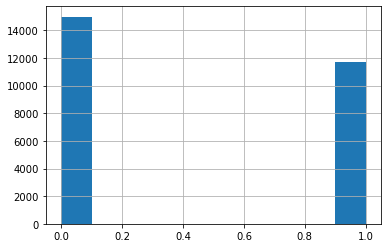

In [59]:
data['is_sarcastic'].hist();

- class 1
- class 0

### Drop `article_link` from dataset

In [60]:
data.drop('article_link', axis=1, inplace=True)

### Get length of each headline and add a column for that

In [61]:
data['headline_length'] = data['headline'].apply(lambda s: len(s))

In [62]:
data.head(2)

,headline,is_sarcastic,headline_length
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84


In [63]:
# Number of words to take from tokenizer(most frequent words)
num_words = 10000

### Create train and test set

In [64]:
# 20% test data
data_test = data[np.arange(data.shape[0]) % 5  == 0]
data_train = data[np.arange(data.shape[0]) % 5  != 0]

### Apply `tensorflow.keras` Tokenizer and get indices for words
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [66]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data_train['headline'])
encodings_train = tokenizer.texts_to_sequences(data_train['headline'])
encodings_test = tokenizer.texts_to_sequences(data_test['headline'])

In [67]:
tokenizer.num_words

10000

### Pad sequences
- Pad each example with a maximum length
- Convert target column into numpy array

In [68]:
maxlen = max(data_train['headline_length'])
encodings_train = pad_sequences(encodings_train, maxlen=maxlen, padding='pre')
encodings_test = pad_sequences(encodings_test, maxlen=maxlen, padding='pre')

### Vocab mapping
- There is no word for 0th index

In [75]:
# All words present in the dataset sorted according to their frequency.
# Note: We only chosse 10000 most-frequent words
tokenizer.word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'on': 7,
 'and': 8,
 'with': 9,
 'is': 10,
 'new': 11,
 'trump': 12,
 'man': 13,
 'from': 14,
 'at': 15,
 'about': 16,
 'you': 17,
 'this': 18,
 'by': 19,
 'after': 20,
 'be': 21,
 'out': 22,
 'up': 23,
 'how': 24,
 'as': 25,
 'it': 26,
 'that': 27,
 'not': 28,
 'are': 29,
 'your': 30,
 'what': 31,
 'his': 32,
 'all': 33,
 'who': 34,
 'more': 35,
 'he': 36,
 'just': 37,
 'will': 38,
 'has': 39,
 'year': 40,
 'why': 41,
 'one': 42,
 'into': 43,
 'report': 44,
 'have': 45,
 'area': 46,
 'over': 47,
 'donald': 48,
 'u': 49,
 'day': 50,
 'says': 51,
 's': 52,
 'can': 53,
 'first': 54,
 'time': 55,
 'woman': 56,
 'like': 57,
 'get': 58,
 'her': 59,
 "trump's": 60,
 'old': 61,
 'no': 62,
 'now': 63,
 'obama': 64,
 'an': 65,
 'off': 66,
 'life': 67,
 'people': 68,
 'than': 69,
 'was': 70,
 'still': 71,
 "'": 72,
 'make': 73,
 'house': 74,
 'women': 75,
 'back': 76,
 'my': 77,
 'i': 78,
 'clinton': 79,
 'down': 80,
 'white': 81,
 'i

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [76]:
num_words = 10000 + 1

### Load Glove Word Embeddings

### Create embedding matrix

In [77]:
embedding_size = 300

In [78]:
EMBEDDING_FILE = 'glove.6B./glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE, encoding='utf8'):
    word = o.split(' ')[0]
    # print(word)
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [79]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in list(tokenizer.word_index.items())[: num_words - 1]:
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Define model
- Using Sequential model instance and then adding Embedding layer, Bidirectional(LSTM) layer. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

In [98]:
model = Sequential()
model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=254,  trainable=False))
model.add(Bidirectional(LSTM(units=20)))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(20))
model.add(Dense(1, activation='sigmoid'))

In [99]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 254, 300)          3000300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                51360     
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 3,054,141
Trainable params: 53,841
Non-trainable params: 3,000,300
_______________________________________

### Compile the model

In [100]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

### Fit the model

In [101]:
model.fit(encodings_train, data_train['is_sarcastic'],  epochs=8, batch_size=64, 
          validation_data=(encodings_test, data_test['is_sarcastic']))

Epoch 1/8
334/334 [==============================] - 8s 24ms/step - loss: 0.5293 - accuracy: 0.7264 - val_loss: 0.4016 - val_accuracy: 0.8218
Epoch 2/8
334/334 [==============================] - 7s 22ms/step - loss: 0.3888 - accuracy: 0.8271 - val_loss: 0.3714 - val_accuracy: 0.8317
Epoch 3/8
334/334 [==============================] - 7s 22ms/step - loss: 0.3308 - accuracy: 0.8586 - val_loss: 0.3353 - val_accuracy: 0.8538
Epoch 4/8
334/334 [==============================] - 7s 22ms/step - loss: 0.2880 - accuracy: 0.8785 - val_loss: 0.3384 - val_accuracy: 0.8542
Epoch 5/8
334/334 [==============================] - 7s 22ms/step - loss: 0.2610 - accuracy: 0.8908 - val_loss: 0.3387 - val_accuracy: 0.8633
Epoch 6/8
334/334 [==============================] - 7s 22ms/step - loss: 0.2302 - accuracy: 0.9067 - val_loss: 0.3363 - val_accuracy: 0.8583
Epoch 7/8
334/334 [==============================] - 7s 22ms/step - loss: 0.2049 - accuracy: 0.9165 - val_loss: 0.3488 - val_accuracy: 0.8600
Epoch 

In [102]:
preds = model.predict_classes(encodings_test)

In [109]:
ns = [i for i in range(10)]
for n in ns:
    print(data['headline'][n])
    print('Predicted: ', preds[n][0])
    print('Actual ', data['is_sarcastic'][n])
    print('_'*90)

former versace store clerk sues over secret 'black code' for minority shoppers
Predicted:  0
Actual  0
__________________________________________________________________________________________
the 'roseanne' revival catches up to our thorny political mood, for better and worse
Predicted:  0
Actual  0
__________________________________________________________________________________________
mom starting to fear son's web series closest thing she will have to grandchild
Predicted:  1
Actual  1
__________________________________________________________________________________________
boehner just wants wife to listen, not come up with alternative debt-reduction ideas
Predicted:  1
Actual  1
__________________________________________________________________________________________
j.k. rowling wishes snape happy birthday in the most magical way
Predicted:  1
Actual  0
__________________________________________________________________________________________
advancing the world's women
Pre

In [104]:
print(classification_report(data_test['is_sarcastic'], preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2995
           1       0.85      0.84      0.85      2347

    accuracy                           0.87      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.87      0.87      0.87      5342

